# Leanding Club Case Study

## Importing required libraries

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#### Reading loans data 

In [6]:
loan_df = pd.read_csv('loan.csv',low_memory=False)

#### Check for duplicate rows

In [7]:
duplicate_rows = loan_df[loan_df.duplicated()]

# Print duplicate rows
print("Duplicate Rows except first occurrence:")
print(duplicate_rows)

Duplicate Rows except first occurrence:
Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m

#### Removing all the columns which contains only NULL values

In [8]:
loan_filt_df = loan_df.dropna(axis=1, how='all').copy()

#### Identifying columns which is not useful OR having single/unique values 

In [9]:
columns_to_drop = [col for col in loan_filt_df.columns if loan_filt_df[col].nunique() == 1]
loan_filt_df.drop(columns=columns_to_drop, inplace=True)

#### Droping columns which is not useful for analysis OR descriptive columns

In [10]:
columns_to_drop=['id', 'member_id', 'url', 'desc','title','emp_title','zip_code','pub_rec_bankruptcies','next_pymnt_d',
                'collection_recovery_fee','out_prncp_inv','recoveries','last_pymnt_d','total_rec_int','total_rec_late_fee',
                'sub_grade','last_credit_pull_d',
                'open_acc','out_prncp','total_acc']
loan_filt_df.drop(columns=columns_to_drop, inplace=True)

#### Remove rows whose loan status is Current

In [11]:
filter_condition = loan_filt_df['loan_status'] == 'Current'
loan_filt_df = loan_filt_df.drop(loan_filt_df[filter_condition].index)
filtered_df_defaulted = loan_filt_df[loan_filt_df['loan_status'] == 'Charged Off']

## Data Standardization

In [12]:
loan_filt_df.int_rate = loan_filt_df.int_rate.apply(lambda x: x.replace('%', '')).astype(float)
loan_filt_df.revol_util = loan_filt_df.revol_util.astype(str).apply(lambda x:x.replace('%','')).astype(str)
loan_filt_df.term = loan_filt_df.term.astype(str).apply(lambda x:x.replace(' months','')).astype(str)
loan_filt_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt
0,5000,5000,4975.0,36,10.65,162.87,B,10+ years,RENT,24000.0,...,1,NaN,NaN,0,13648,83.70,5863.155187,5833.84,5000.00,171.62
1,2500,2500,2500.0,60,15.27,59.83,C,< 1 year,RENT,30000.0,...,5,NaN,NaN,0,1687,9.40,1008.710000,1008.71,456.46,119.66
2,2400,2400,2400.0,36,15.96,84.33,C,10+ years,RENT,12252.0,...,2,NaN,NaN,0,2956,98.50,3005.666844,3005.67,2400.00,649.91
3,10000,10000,10000.0,36,13.49,339.31,C,10+ years,RENT,49200.0,...,1,35.0,NaN,0,5598,21,12231.890000,12231.89,10000.00,357.48
5,5000,5000,5000.0,36,7.90,156.46,A,3 years,RENT,36000.0,...,3,NaN,NaN,0,7963,28.30,5632.210000,5632.21,5000.00,161.03


### Derived Metrics

#### Converting columns data type to datetime 

In [13]:
# Converting columne to datetime type
loan_filt_df['issue_d'] = pd.to_datetime(loan_filt_df.issue_d, format='%b-%y')
# Create derived date related columns
loan_filt_df['issue_month'] = loan_filt_df.issue_d.dt.month
loan_filt_df['issue_year'] = loan_filt_df.issue_d.dt.year

#### calculating funded amount ratio

In [14]:
loan_filt_df['funded_loan_amts_ratio'] = loan_filt_df['funded_amnt_inv']/loan_filt_df['loan_amnt']
loan_filt_df['funded_loan_amts_ratio']

0        0.995000
1        1.000000
2        1.000000
3        1.000000
5        1.000000
           ...   
39712    0.430000
39713    0.102941
39714    0.265000
39715    0.130000
39716    0.106667
Name: funded_loan_amts_ratio, Length: 38577, dtype: float64

#### Changing data type of  Employee length to float

In [15]:
def checkEmpLen(x,col):
    #print(x)
    if('<' in x):
        return 0
    elif('+' in x):
        return x.split('+')[0]
    elif(' ' in x):
        return x.split(' ')[0]
    else:
        return x

loan_filt_df.emp_length = loan_filt_df.emp_length.astype(str).apply(lambda x:x.replace('%','')).astype(str)
loan_filt_df['emp_length']= loan_filt_df['emp_length'].apply(checkEmpLen, args=('emp_length',))
loan_filt_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,issue_month,issue_year,funded_loan_amts_ratio
0,5000,5000,4975.0,36,10.65,162.87,B,10,RENT,24000.0,...,0,13648,83.70,5863.155187,5833.84,5000.00,171.62,12,2011,0.995
1,2500,2500,2500.0,60,15.27,59.83,C,0,RENT,30000.0,...,0,1687,9.40,1008.710000,1008.71,456.46,119.66,12,2011,1.000
2,2400,2400,2400.0,36,15.96,84.33,C,10,RENT,12252.0,...,0,2956,98.50,3005.666844,3005.67,2400.00,649.91,12,2011,1.000
3,10000,10000,10000.0,36,13.49,339.31,C,10,RENT,49200.0,...,0,5598,21,12231.890000,12231.89,10000.00,357.48,12,2011,1.000
5,5000,5000,5000.0,36,7.90,156.46,A,3,RENT,36000.0,...,0,7963,28.30,5632.210000,5632.21,5000.00,161.03,12,2011,1.000


## Univariate Analysis

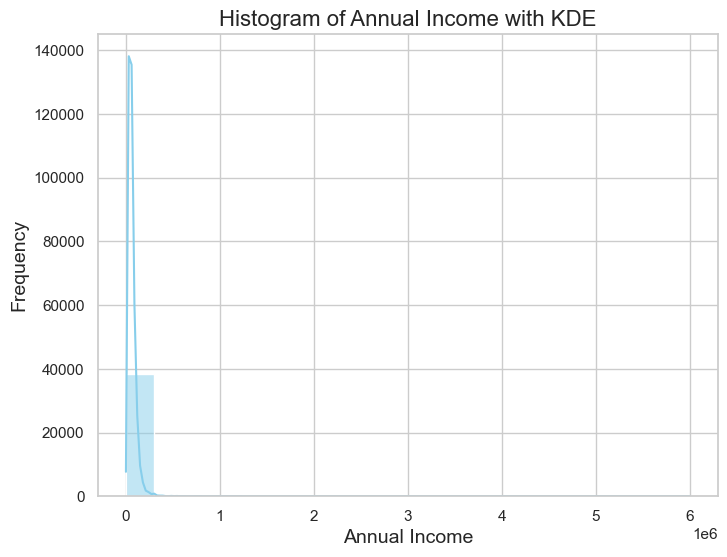

In [16]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.histplot(loan_filt_df['annual_inc'], kde=True, color='skyblue', bins=20)  # Set the number of bins as needed
plt.title('Histogram of Annual Income with KDE', fontsize=16)
plt.xlabel('Annual Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

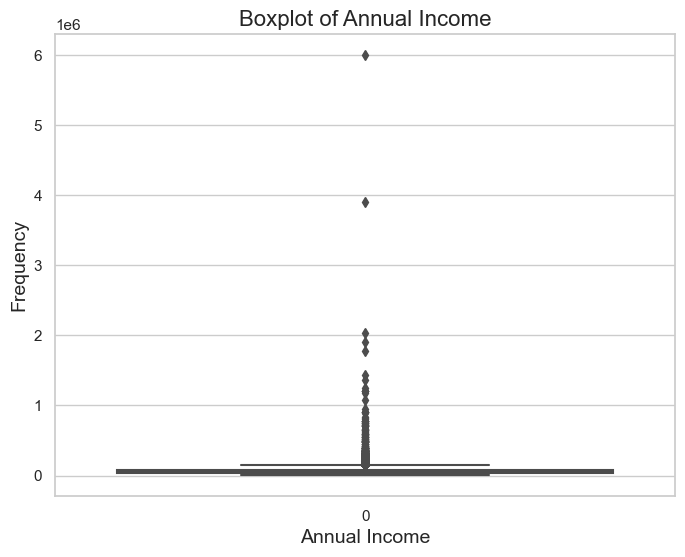

In [17]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.boxplot(loan_filt_df['annual_inc'])  # Set the number of bins as needed
plt.title('Boxplot of Annual Income', fontsize=16)
plt.xlabel('Annual Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [18]:
upper_bound = loan_filt_df['annual_inc'].quantile(0.75)
lower_bound= loan_filt_df['annual_inc'].quantile(0.25)
IQR = upper_bound - lower_bound 
lower_bound = lower_bound - 1.5 * IQR
upper_bound = upper_bound + 1.5 * IQR

# Remove outliers and create a new DataFrame without outliers
filtered_annual_inc_df_middle = loan_filt_df[(loan_filt_df['annual_inc'] >= lower_bound) & (loan_filt_df['annual_inc'] <= upper_bound)]

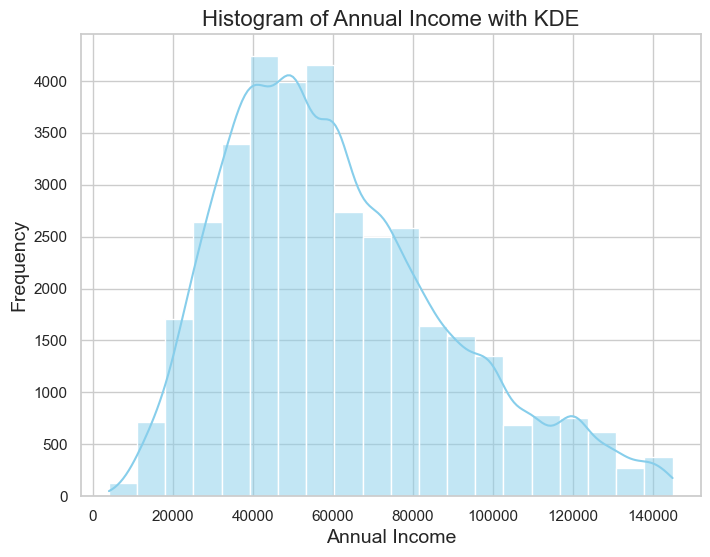

In [19]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.histplot(filtered_annual_inc_df_middle['annual_inc'], kde=True, color='skyblue', bins=20)  # Set the number of bins as needed
plt.title('Histogram of Annual Income with KDE', fontsize=16)
plt.xlabel('Annual Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

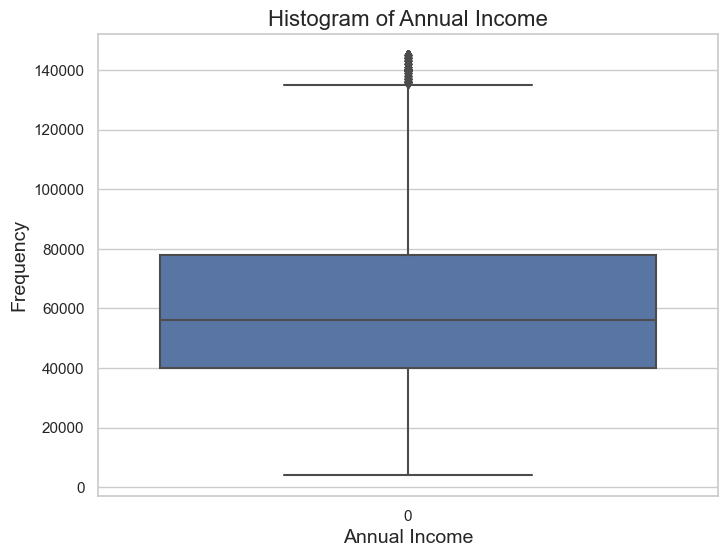

In [20]:
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.boxplot(filtered_annual_inc_df_middle['annual_inc'])  # Set the number of bins as needed
plt.title('Histogram of Annual Income', fontsize=16)
plt.xlabel('Annual Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

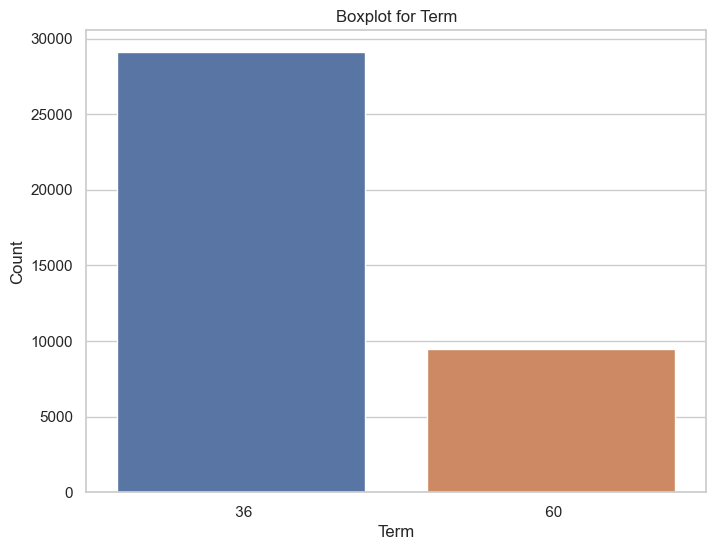

In [21]:
term_counts = loan_filt_df.term.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=term_counts.index, y=term_counts.values)
plt.title('Boxplot for Term')
plt.xlabel('Term')
plt.ylabel('Count')
plt.show()

## Bivariate Graphs

#### Making bins for interest rates

In [22]:
# Interest Rate
# Making bins for interest rates
bin_edges = [0,5, 10, 15, 20, 25]
bin_labels = ['0-5', '6-10', '11-15', '16-20', '21-25']
# Create bins based on int_rate column
loan_filt_df['int_rate_bins'] = pd.cut(loan_filt_df['int_rate'], bins=bin_edges,labels=bin_labels)

#### Preparing grouped Data for Analysis

In [23]:
# Group data by int_rate_bins and count the number of occurrences for each bin
grouped_int_rate_bins_data = loan_filt_df.groupby(by=['int_rate_bins','loan_status'])['loan_status'].count().reset_index(name='count')

# Group data by int_rate_bins and count the number of occurrences for each bin
grouped_issue_year_data = loan_filt_df.groupby(by=['issue_year','loan_status'])['loan_status'].size().reset_index(name='count')

# Group data by int_rate_bins and count the number of occurrences for each bin
# DTI vs loan status
loan_filt_df['dti_groups'] = pd.cut(loan_filt_df['installment'], bins=6,precision =0)
grouped_dti_groups_data = loan_filt_df.groupby(by=['dti_groups','loan_status'])['loan_status'].count().reset_index(name='count')

# Group data by int_rate_bins and count the number of occurrences for each bin
loan_filt_df['installment_groups'] = pd.cut(loan_filt_df['installment'], bins=10,precision =0)
grouped_installment_groups_data = loan_filt_df.groupby(by=['installment_groups','loan_status'])['loan_status'].count().reset_index(name='count')

grouped_inq_last_6mths_data = loan_filt_df.groupby(['inq_last_6mths', 'loan_status']).size().reset_index(name='count')

# Sample grouped data (replace this with your grouped data)
grouped_grade_data = loan_filt_df.groupby(by=['grade','loan_status']).size().reset_index(name='count')

full_paid_df = loan_filt_df[loan_filt_df['loan_status'] == 'Fully Paid']
full_paid_grouped_data = full_paid_df.groupby('home_ownership')['loan_status'].count().reset_index()

charged_off_df = loan_filt_df[loan_filt_df['loan_status'] == 'Charged Off']
charged_off_grouped_data = charged_off_df.groupby('home_ownership')['loan_status'].count().reset_index()

#### Interest Rate Vs Paid Loan Status Garph

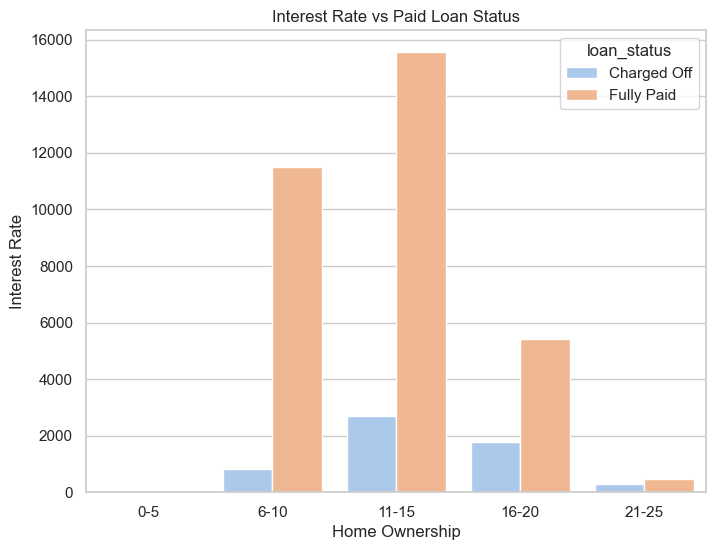

In [24]:
# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.barplot(x='int_rate_bins', y='count',hue='loan_status', data=grouped_int_rate_bins_data, palette='pastel')  # Create the bar plot
plt.title('Interest Rate vs Paid Loan Status')
plt.ylabel('Interest Rate')
plt.xlabel('Home Ownership')
plt.show()

#### Graph between Loan Ration and Loan Status

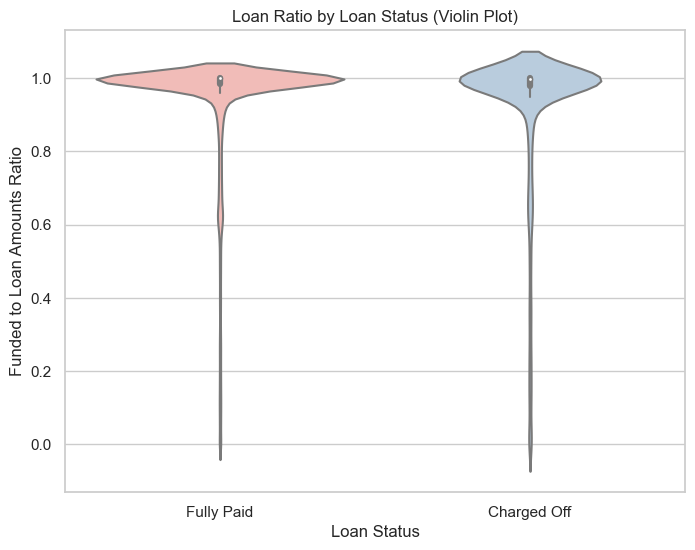

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.violinplot(x='loan_status', y='funded_loan_amts_ratio', data=loan_filt_df, palette="Pastel1")
plt.xlabel('Loan Status')
plt.ylabel('Funded to Loan Amounts Ratio')
plt.title('Loan Ratio by Loan Status (Violin Plot)')
plt.show()

#### Obervation :: Charged Off loans have higher loan amounts than fully paid loans.

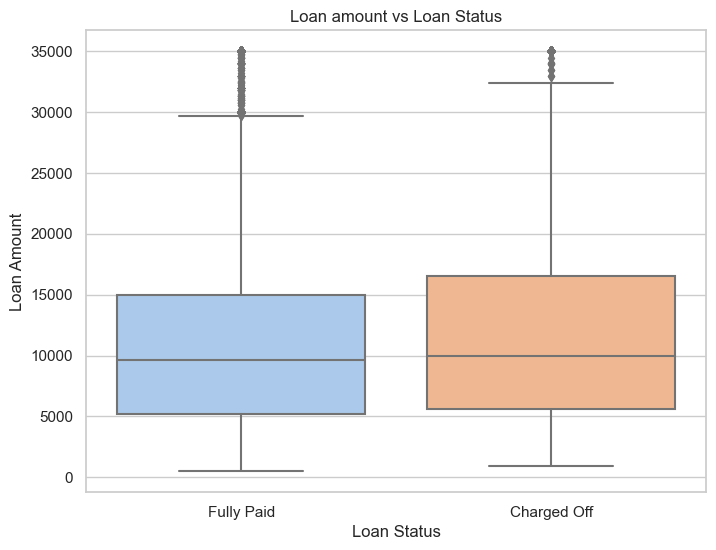

In [26]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.boxplot(x='loan_status', y='loan_amnt', data=loan_filt_df, palette='pastel')  # Create the bar plot
plt.title('Loan amount vs Loan Status')
plt.ylabel('Loan Amount')
plt.xlabel('Loan Status')
plt.show()

 #### Obervation : Higest rate of intereset causes more defaulter

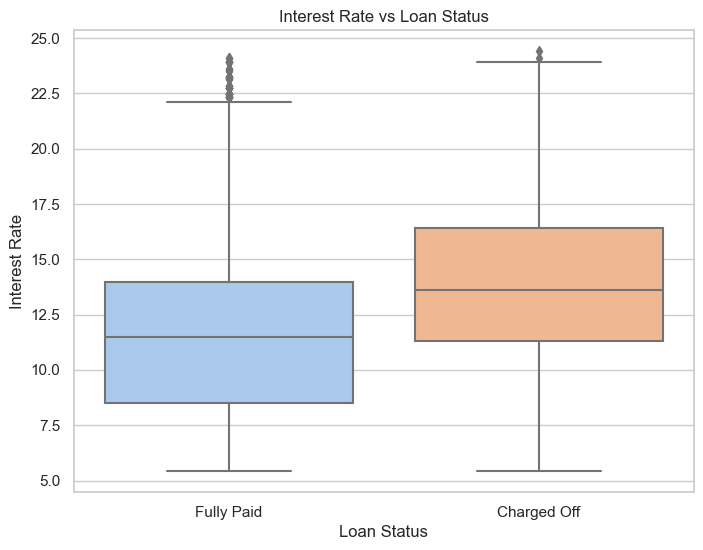

In [27]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.boxplot(x='loan_status', y='int_rate', data=loan_filt_df, palette='pastel')  # Create the bar plot
plt.title('Interest Rate vs Loan Status')
plt.ylabel('Interest Rate')
plt.xlabel('Loan Status')
plt.show()

#### Observation : Even though loan applicants are increasing with the years, there is a much higher chance of the loan getting paid off.

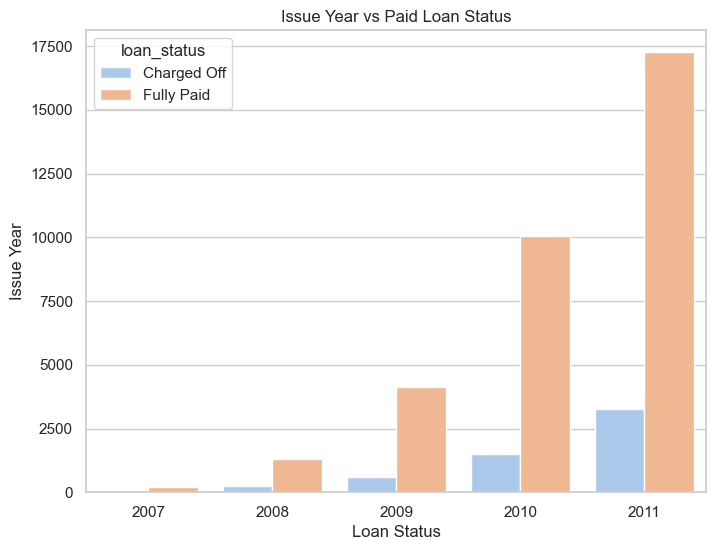

In [28]:

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.barplot(x='issue_year', y='count',hue='loan_status', data=grouped_issue_year_data, palette='pastel')  # Create the bar plot
plt.title('Issue Year vs Paid Loan Status')
plt.ylabel('Issue Year')
plt.xlabel('Loan Status')
plt.show()

# Defaulting people are increasing over the years

#### Finding out Graph between DTI and loan status

In [51]:
# DTI vs loan status
loan_filt_df['dti_groups'] = pd.cut(loan_filt_df['installment'], bins=6,precision =0)

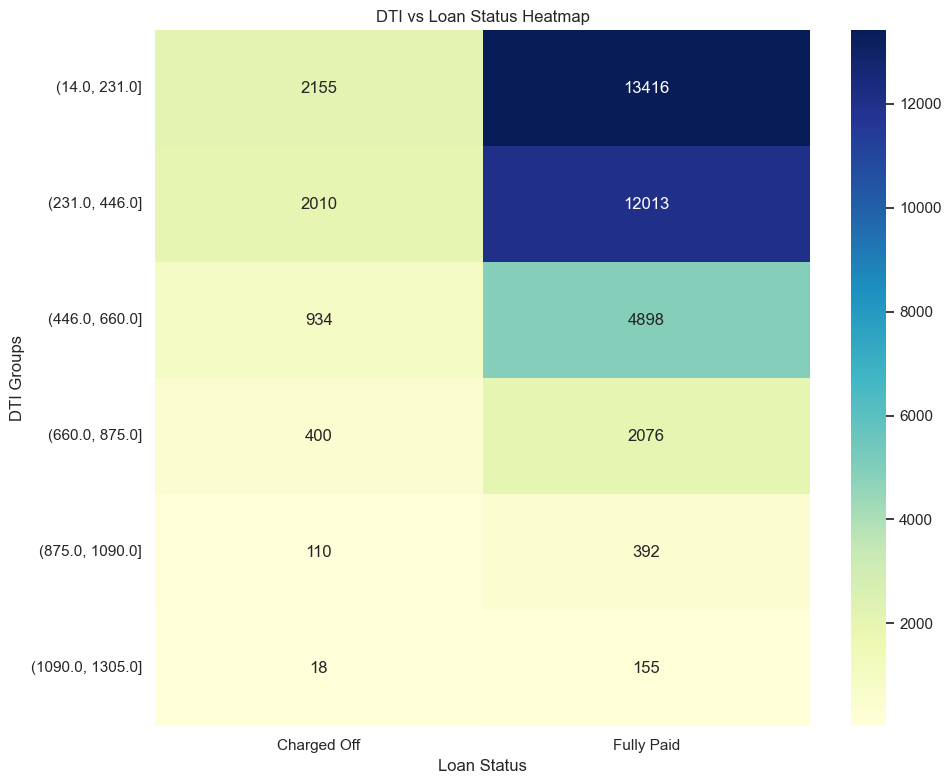

In [30]:

# Pivot the data to create a matrix for the heatmap
pivot_data = grouped_dti_groups_data.pivot(index='dti_groups', columns='loan_status', values='count')

# Set the figure size and style
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create a heatmap using Seaborn
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt='g')

# Customize plot labels and title
plt.title('DTI vs Loan Status Heatmap')
plt.xlabel('Loan Status')
plt.ylabel('DTI Groups')

# Show the plot
plt.tight_layout()
plt.show()

 #### Graph between installment bins vs Loan Status

#### Observation :: If the installment is less, there is higher fully paid loans.	In each installment bin, it has been observed that fully paid loan status has a greater number 	of records wrt charged off status.

In [ ]:
# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.barplot(x='dti_groups', y='count',hue='loan_status', data=grouped_dti_groups_data, palette='pastel')  # Create the bar plot
plt.title('Installment bins vs Count of Loan Status')
plt.xlabel('Installment bins')
plt.ylabel('Count of loan status')
plt.show()

#### Observation : Lower DTI has significantly higher loan status of fully paid.

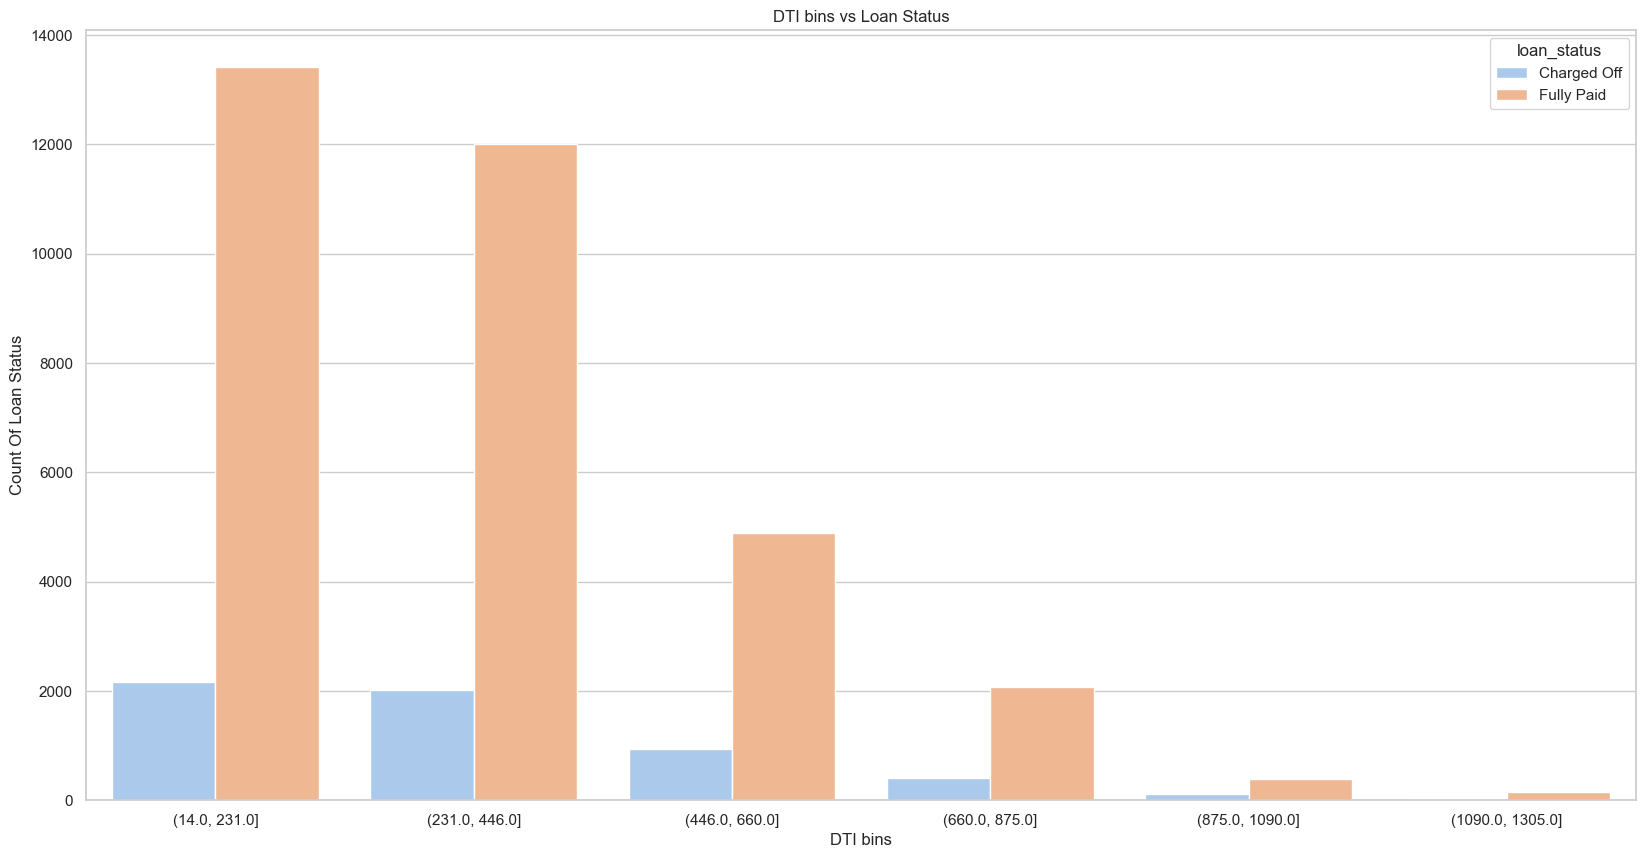

In [54]:
# Create a bar plot using Seaborn
plt.figure(figsize=(20, 10))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.barplot(x='dti_groups', y='count',hue='loan_status', data=grouped_dti_groups_data, palette='pastel')  # Create the bar plot
plt.title('DTI bins vs Loan Status')
plt.xlabel('DTI bins')
plt.ylabel('Count Of Loan Status')
plt.show()

#### Different Graphs Between Installment Vs Loan Status

#### Observation : Less number of installment has more number of fully paid loan status records.

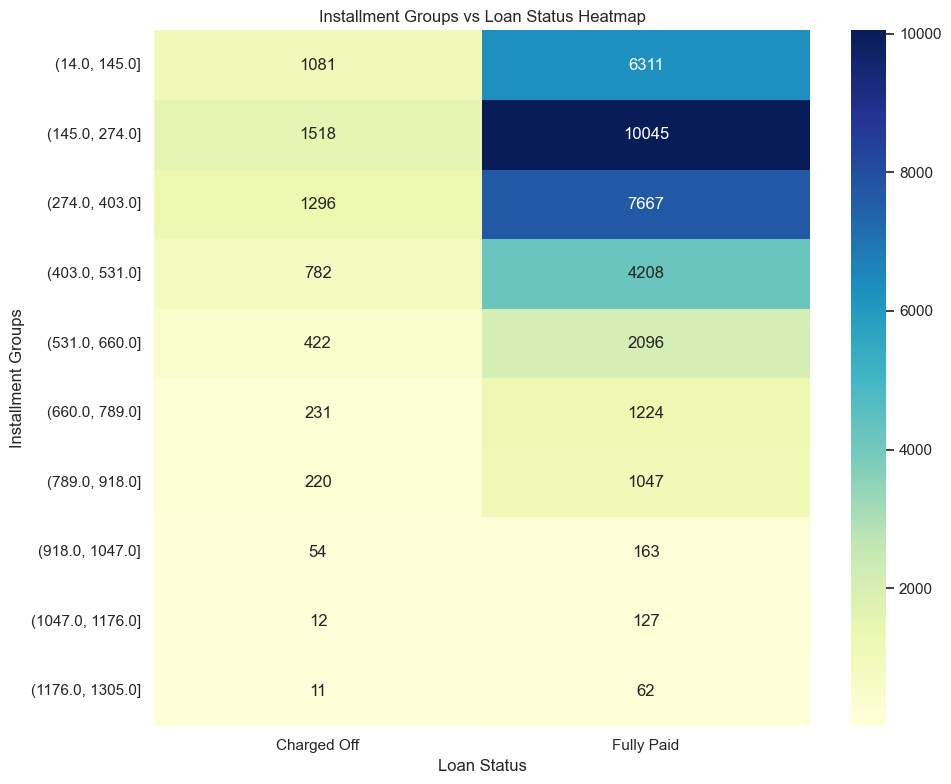

In [55]:

# Pivot the data to create a matrix for the heatmap
pivot_data = grouped_installment_groups_data.pivot(index='installment_groups', columns='loan_status', values='count')

# Set the figure size and style
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create a heatmap using Seaborn
sns.heatmap(pivot_data, annot=True, cmap="YlGnBu", fmt='g')

# Customize plot labels and title
plt.title('Installment Grovs Loan Status Heatmap')
plt.xlabel('Loan Status')
plt.ylabel('Installment Groups')

# Show the plot
plt.tight_layout()
plt.show()

#### Observation :: in the last 6 months it can be seen that People who fully paid the loan call more often to the banck then the people who charged off

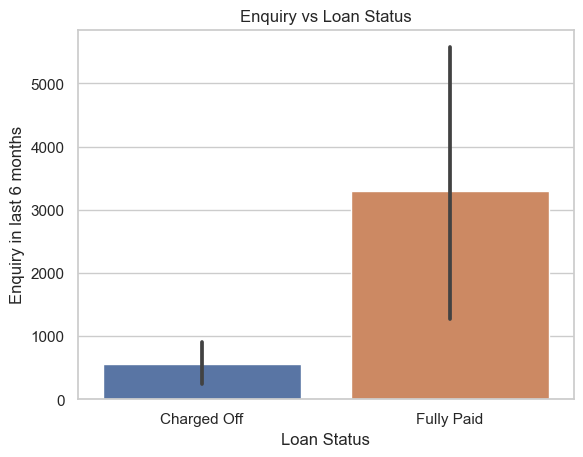

In [34]:
sns.barplot(x='loan_status', y='count', data=grouped_installment_groups_data)
plt.title('Enquiry vs Loan Status')
plt.ylabel('Enquiry in last 6 months')
plt.xlabel('Loan Status')
plt.show()

#### Obserevations : Applicants who rent would defer loans more.

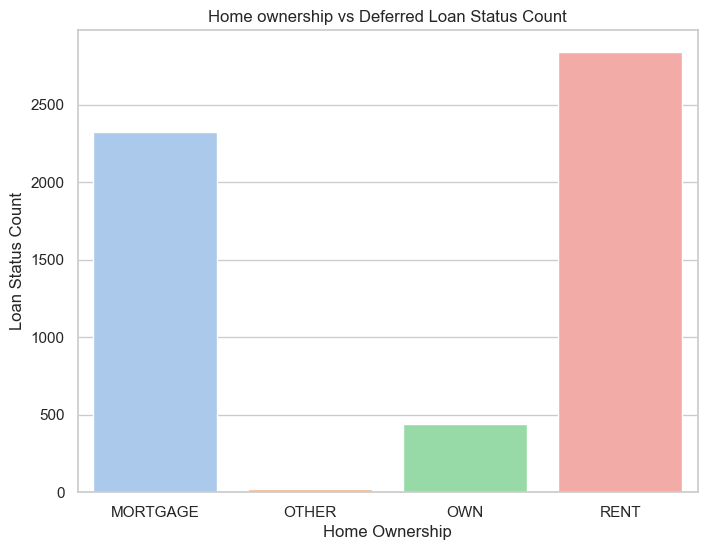

In [36]:
plt.figure(figsize=(8, 6))  # Set the figure size
sns.set(style="whitegrid")  # Set the style of the plot
sns.barplot(x='home_ownership', y='loan_status', data=charged_off_grouped_data, palette='pastel')  # Create the bar plot
plt.title('Home ownership vs Deferred Loan Status Count')
plt.ylabel('Loan Status Count')
plt.xlabel('Home Ownership')
plt.show()

#### Finding out Loan Status on the Basis grade given to customers

#### Observation : 
#### Applicants with grade A, B,C are most likely to pay off the loan.
#### Applicants with grade G is most likely to default the loan.

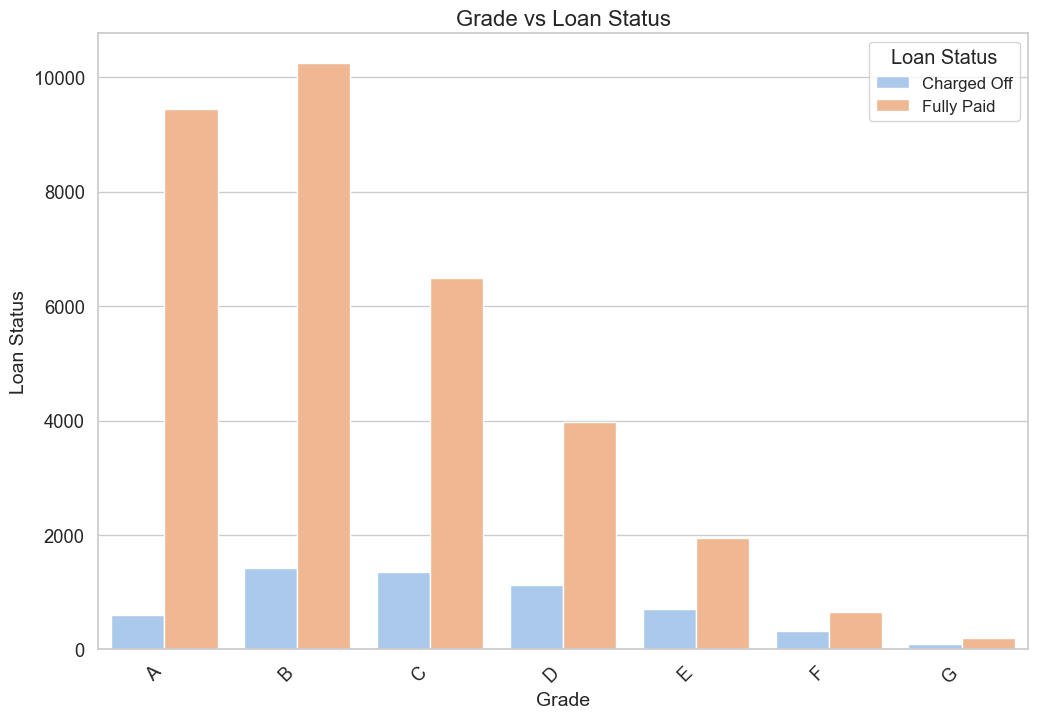

In [37]:

# max_count = 3000
# Create a larger bar plot with different colors for loan_status
plt.figure(figsize=(12, 8))  # Increase the figure size
sns.set(style="whitegrid", font_scale=1.2)  # Set the style and font scale of the plot

# # Create the bar plot with hue
sns.barplot(x='grade', y='count', hue='loan_status', data=grouped_grade_data, palette='pastel')  

plt.title('Grade vs Loan Status', fontsize=16)  # Set the title and font size
plt.xlabel('Grade', fontsize=14)  # Set the x-axis label and font size
plt.ylabel('Loan Status', fontsize=14)  # Set the y-axis label and font size
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Loan Status', fontsize=12)  # Set legend title and font size
# plt.ylim(0, max_count)
plt.show()

## Multivariate Plots

<Axes: xlabel='home_ownership', ylabel='annual_inc'>

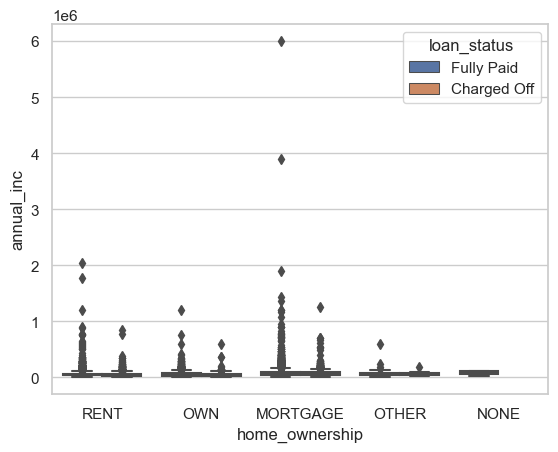

In [39]:
sns.boxplot(data = loan_filt_df ,x= 'home_ownership', y = 'annual_inc',hue='loan_status')

In [40]:
upper_bound = loan_filt_df['annual_inc'].quantile(0.8)
lower_bound= loan_filt_df['annual_inc'].quantile(0.2)

#### Observations:
##### Applicants who rent and have less annual income & applications with higher annual income and mortgage are more likely to have fully paid loan status.

<Axes: xlabel='home_ownership', ylabel='annual_inc'>

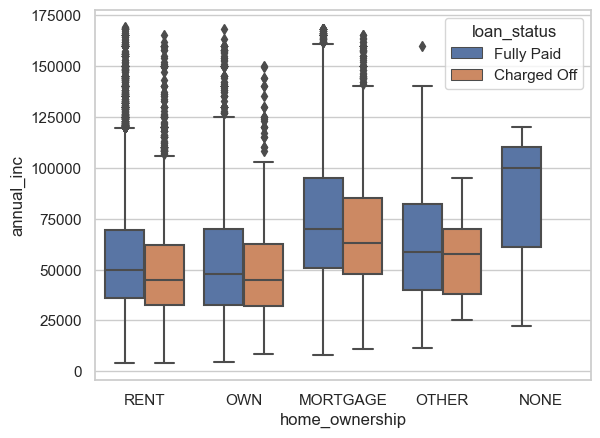

In [42]:
IQR = upper_bound - lower_bound 
lower_bound = lower_bound - 1.5 * IQR
upper_bound = upper_bound + 1.5 * IQR
filtered_df_middle = loan_filt_df[(loan_filt_df['annual_inc'] >= lower_bound) & (loan_filt_df['annual_inc'] <= upper_bound)]
sns.boxplot(data = filtered_df_middle,x='home_ownership',y='annual_inc',hue='loan_status')

In [43]:
loan_filt_df.groupby('home_ownership')['loan_status'].count().reset_index()

,home_ownership,loan_status
0,MORTGAGE,17021
1,NONE,3
2,OTHER,98
3,OWN,2975
4,RENT,18480


#### Observation :: 
###### here with the below plot we can say , Applicants with more annual income has paid off their loans more likely

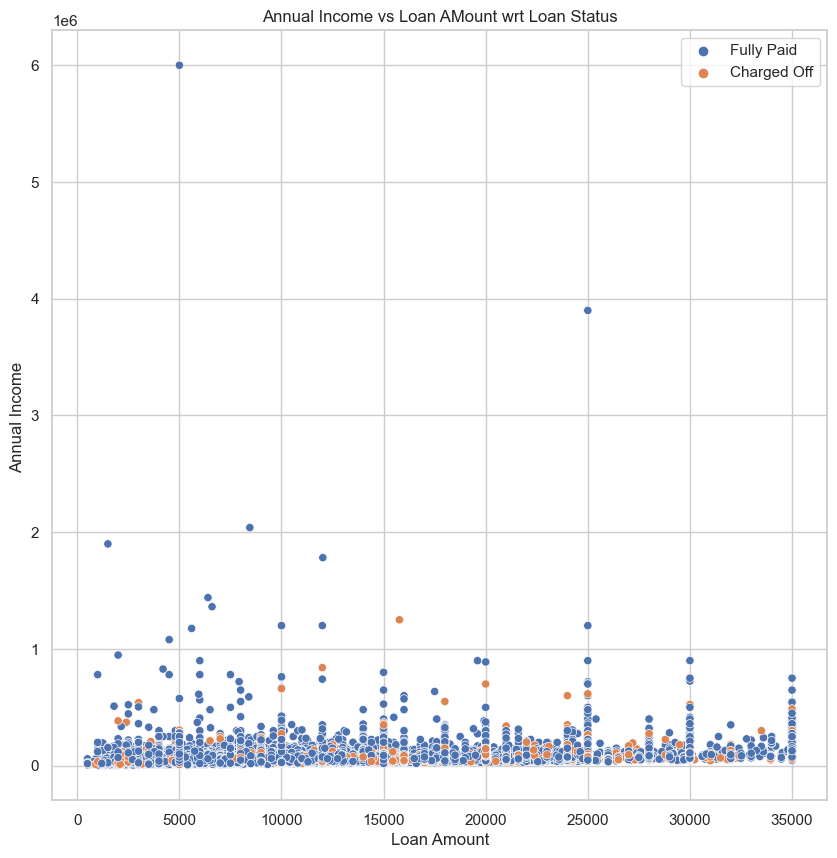

In [60]:
plt.figure(figsize=(10, 10))
sns.scatterplot( x = "loan_amnt", 
                 y = "annual_inc", 
                 data = loan_filt_df, 
                 hue = "loan_status")
plt.xlabel('Loan Amount')
plt.ylabel('Annual Income ')
plt.title('Annual Income vs Loan AMount wrt Loan Status')
plt.legend()
plt.show()

<Axes: xlabel='loan_status', ylabel='count'>

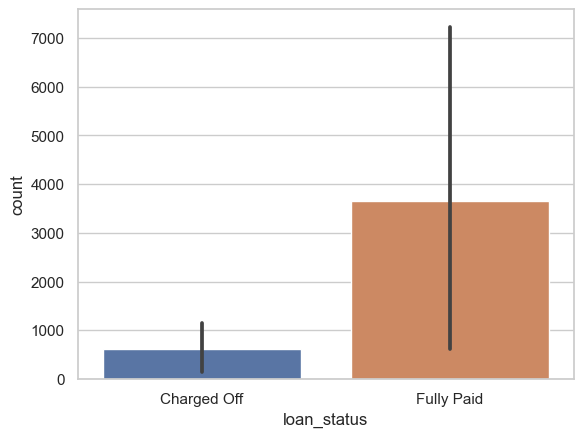

In [46]:
grouped_data = loan_filt_df.groupby(['inq_last_6mths', 'loan_status']).size().reset_index(name='count')
sns.barplot(x='loan_status', y='count', data=grouped_data)

#### Obeserevations : Maximum number of defaulters are from the state of CA

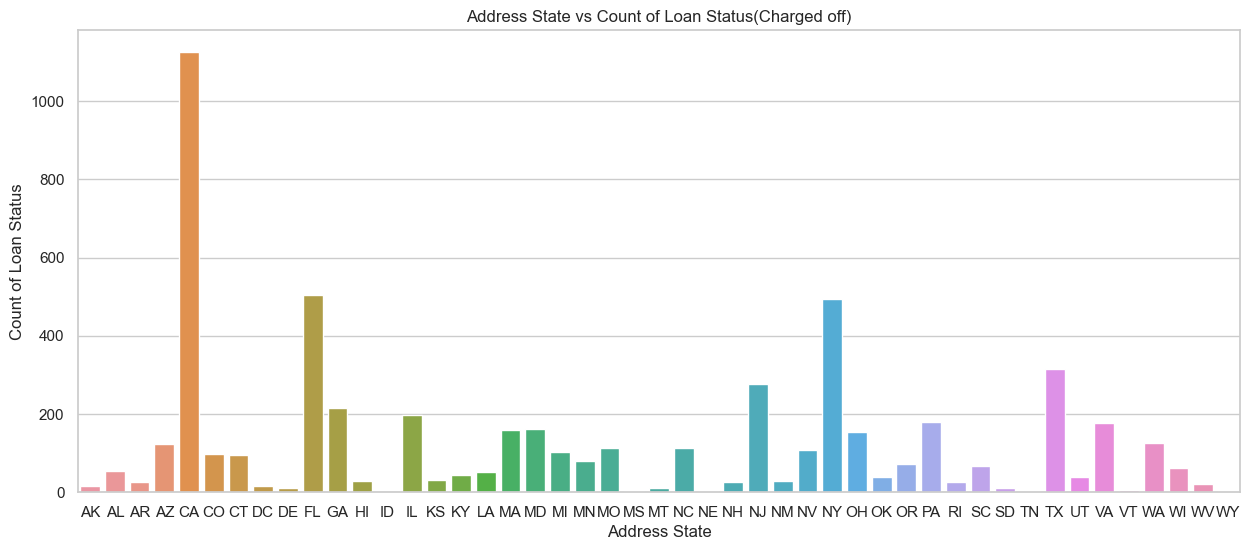

In [47]:
plt.figure(figsize=(15, 6))
grouped_data = filtered_df_defaulted.groupby(by=['addr_state', 'loan_status']).size().reset_index(name='count')
sns.barplot(x='addr_state', y='count', data=grouped_data)
plt.title('Address State vs Count of Loan Status(Charged off)')
plt.ylabel('Count of Loan Status')
plt.xlabel('Address State')
plt.show()

#### Observations

##### Applicant with more annual income have higher rate of paid off 

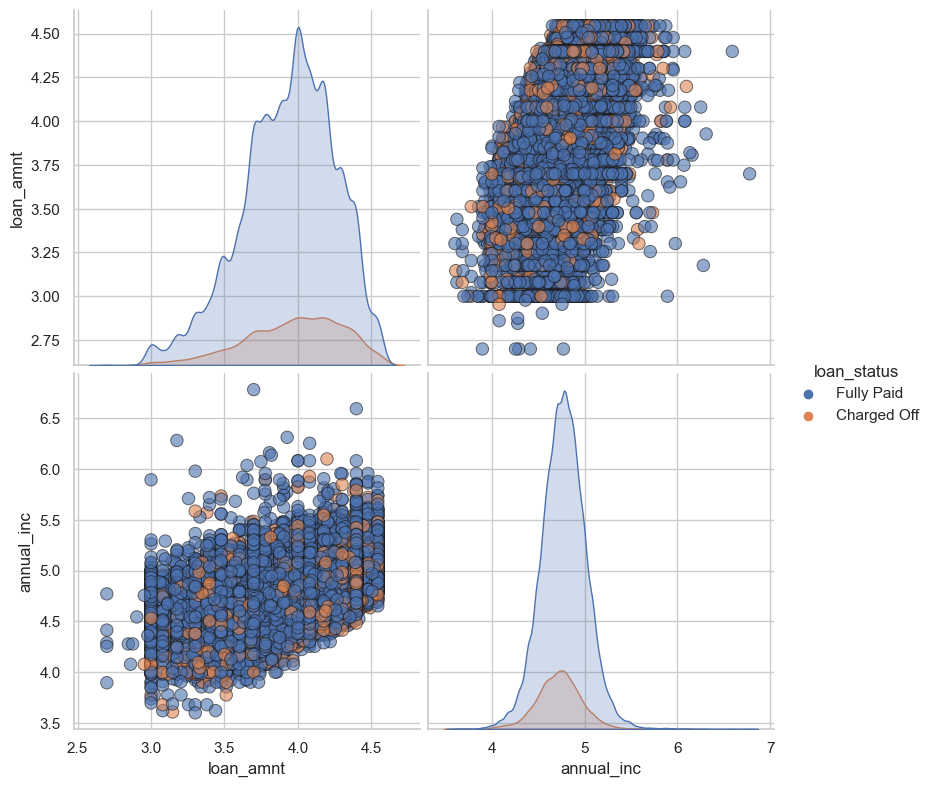

In [48]:
# Lets draw a pair plot for multivariate analysis
new_loan_filt_df = loan_filt_df[["loan_amnt","annual_inc","loan_status"]].copy()
# Take the log of below variables as they are heavily skewed
new_loan_filt_df['loan_amnt'] = np.log10(new_loan_filt_df['loan_amnt'])
new_loan_filt_df['annual_inc'] = np.log10(new_loan_filt_df['annual_inc'])
sns.pairplot(new_loan_filt_df, hue = 'loan_status', diag_kind = 'kde',plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},height = 4)

#### Observations::

#### Funded amount and loan amount are highly correlated fields, we can create a ratio to understand the correlation between loan approved to loan amount
#### 	There is a very high correlation between number of installment and total payments. 
####     Funded amount and total payment.
####     DTI and Annual income has negative correlation.

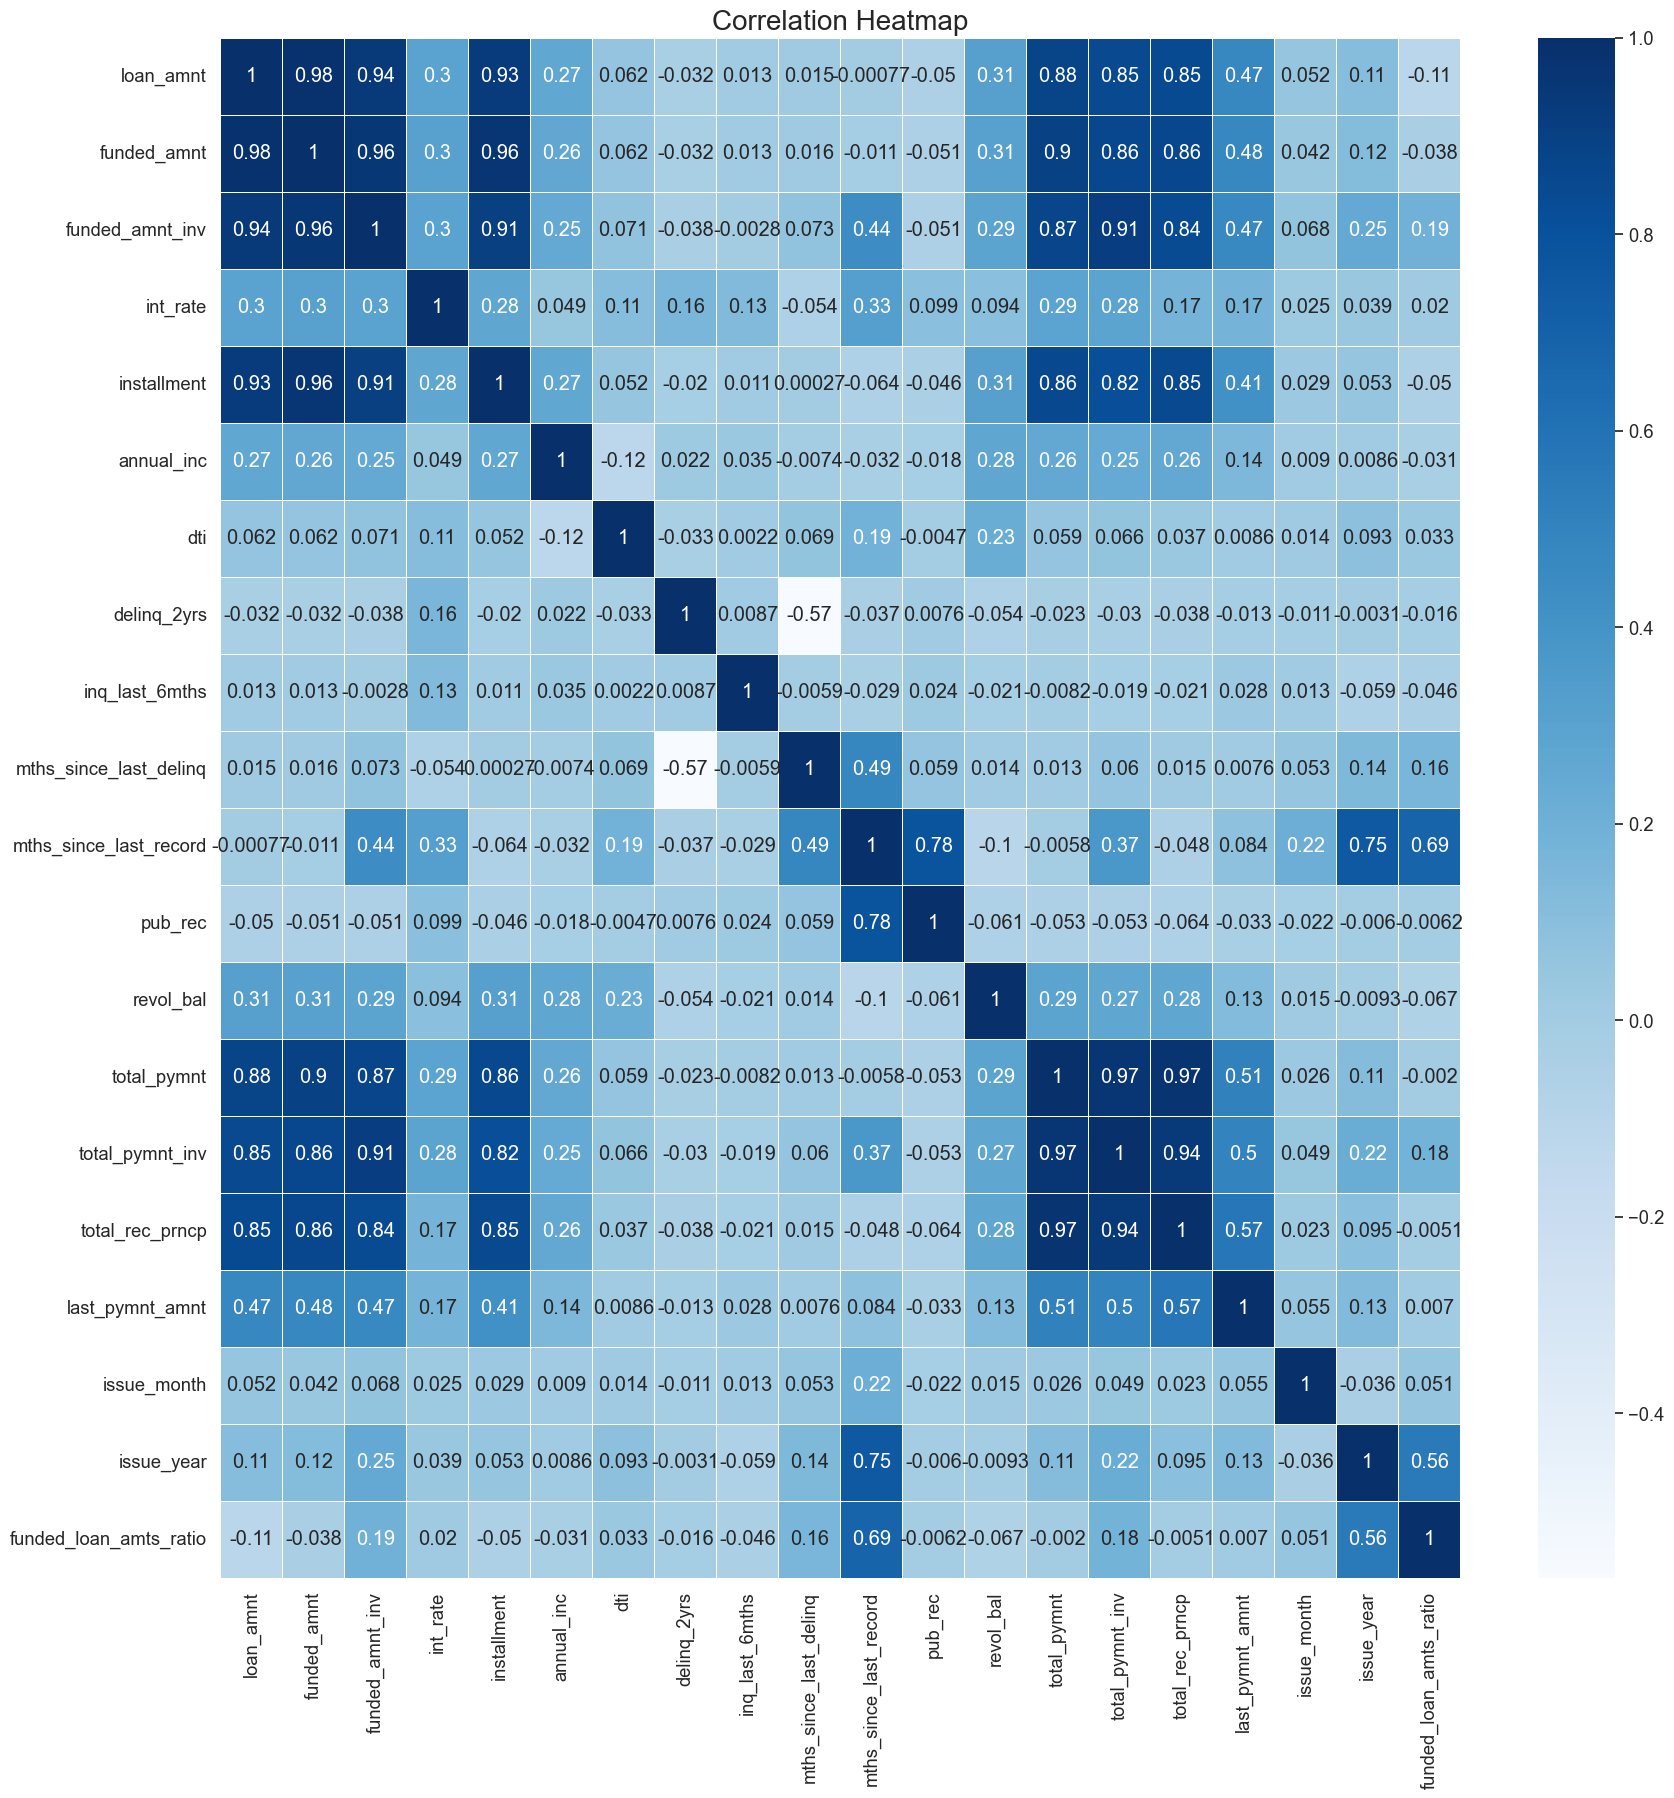

In [49]:
# Calculate the correlation matrix (replace 'df' with your actual DataFrame if you want to show correlations)
correlation_matrix = loan_filt_df.corr(numeric_only = [False])

# Enlarge the heatmap by adjusting the figure size
plt.figure(figsize=(20, 20))  # Set the width and height according to your preference

# Create a heatmap of the correlation matrix
sns.set(font_scale=1.2)  # Set font scale for better readability
sns.heatmap(correlation_matrix,  linewidths=.5, annot = True, cmap='Blues')
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

In [50]:
loan_filt_df['verification_status'].unique() 

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)